Analyse des données

Préparation des données avec pandas


In [190]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

pd.set_option('display.float_format', lambda x: f'{x :.2f}')
from cleaner import DataCleaner
from get_dataframes import GetDataframes
import hjson

from datetime import datetime

import matplotlib.pyplot as plt
import explo_data_analysis.eda_movies as eda

with open("config.hjson") as fp:
    config = hjson.load(fp)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


- On importe la dataframe "title_basics" qui contient les infos pour tout les films de la base de données.
- On enlève tout les films à caractère pornographique de notre liste.
- On nettoie les /N et les transforme en 0.
- On change les types de données des colonnes (float en int, etc...)
- On merge la dataframe "title_basics" avec "tmdb_full" pour obtenir des infos supplémentaires sur chaque film.
- On supprime les colonnes inutiles.
- On supprime les lignes pour lesquelles on a des valeurs manquantes suite au merging.
- On transforme les données dans les colonnes ayant plusieurs valeurs et les on les transforme en listes.
- On importe les dataframes "name_basics", "title_akas" et "title_principals".
- On merge la dataframe "title_akas" avec "tmdb_full".
- On filtre les films ayant eu une adaptaion en FR uniquement.
- On filtre seulement les films qui sont "Released".
- On nettoie "name_basics" comme précédement.
- On merge "name_basics", "title_principals" et on trie les acteurs, directeurs et autres dans un autre dataframe.
- On merge chaque dataframe (acteurs, directeurs, etc...) avec la liste des films qui étaient déjà merged avec tmdb.

In [191]:
datas = GetDataframes(config)
link = "movies"
df = datas.get_dataframes(
    link,
)

2023-10-31 16:00:38 INFO     TSV files already exist.
2023-10-31 16:00:38 INFO     Parquet loaded ! Importing movies...
2023-10-31 16:00:38 INFO     Dataframe movies ready to use!


- On créée une visualisation pour voir la distribution des notes moyennes de chaque film, le nombre de films par décénnie et le total de votes par décénnie.

In [192]:
eda.show_total_films_decade_plotly(df)

- On cherche quel genre de films est le plus répandu dans le dataset filtré

In [193]:
total_genres = df.explode('titre_genres')['titre_genres'].value_counts()[::-1]

# plt.figure(figsize=(10, 8))
# plt.barh(
#     total_genres.index,
#     total_genres.values,
#     color='royalblue',
#     edgecolor='black'
# )
# plt.title('Répartition des genres de films', fontsize=16)
# plt.xlabel('Nombre de films', fontsize=14)
# plt.ylabel('Genres', fontsize=14)
# plt.gca().invert_yaxis()
# plt.show()

def graph_by_genre(df):
    total_genres = df.explode('titre_genres')['titre_genres'].value_counts()[::-1]
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=total_genres.values,
        y=total_genres.index,
        orientation="h",
        showlegend=False,
        marker=dict(
            color='royalblue',
            line=dict(color='black', width=1))
    ))

    fig.update_layout(
        title= "Répartition des genres de films",
        xaxis_title="Total",
        yaxis_title="Genres",
        autosize=True,
        height= 1000,
    )
    fig.show()

graph_by_genre(df)

- On peut voir que le nombre de films en dessous des années 1960 est très bas et nous décidons de ne pas les garder.
- Les films ayant moins de 5 en note moyenne ne nous intéressent pas non plus.
- Et les films ayant reçu trop peu de votes sont aussi enlevés.

**Delete les films en dessous de 1960**

In [194]:
condi =(
    (df["titre_date_sortie"] >= 1960) &
    (df["rating_avg"] >= 5) &
    (df["rating_votes"] >= 5000)
)

df = df[condi].reset_index(drop='index')

- Ici nous filtrons les genres qui n'ont que peu d'interet pour le cinéma.

In [ ]:
# Film-Noir      579
# Sport          588
# Musical       1108
# Western       1492
# History       1629
# Animation     1631
# Biography     1661
# War           1690
# Family        2145
# Sci-Fi        2214
# Fantasy       2469
# Mystery       3462
# Horror        4971
# Adventure     6078
# Thriller      6435
# Crime         7790
# Romance       7794
# Action        8199
# Comedy       14990
# Drama        28689


In [195]:
genres_ = ["Music", "Documentary", "Reality-TV", "News"]
df = df[df['titre_genres'].apply(lambda x: all(g not in x for g in genres_))]

In [196]:
graph_by_genre(df)

- On peut désormais ré-afficher la distribution des notes moyennes, le total des films par décénnie et le nombre total des votes par décénnies

In [128]:
eda.show_total_films_decade_plotly(df)

- On cherche des informations sur la durée des films en minutes

In [58]:
def boxplot(df: pd.DataFrame):
    fig = px.box(
        data_frame = df,
        # x = "cuts",
        y = "titre_duree",
        # color = "cuts",
        #  ['all', 'outliers', 'suspectedoutliers', False]
        points="outliers",
    )
    fig.update_layout(
        title="Durée des Films",
        # xaxis_title="Décénnie",
        yaxis_title="Durée des Films",
        showlegend=False
        # legend=dict(
        #     yanchor="top",
        #     y=0.99,
        #     xanchor="left",
        #     x=0.01
        # )
    )

    fig.show()

In [59]:
# plt.figure(figsize=(10, 6))
# plt.boxplot(
#     df["titre_duree"],
#     patch_artist=True
# )
# plt.title("Durée des films en minutes")
# plt.tight_layout()
# plt.show()


boxplot(df)

In [60]:
df[(df["titre_duree"] > 210) & (df["titre_duree"] < 400)]

titre_id                     titre_str  titre_date_sortie  \
846    tt0056172            Lawrence of Arabia               1962   
1769   tt0059245  The Greatest Story Ever Told               1965   
2251   tt0060847                     The Ashes               1965   
2732   tt0062663                   L'amour fou               1969   
2882   tt0063084      The Hour of the Furnaces               1968   
...          ...                           ...                ...   
34660  tt7200370           Season of the Devil               2018   
34755  tt7290778             The Wild Frontier               2017   
35343  tt8020896     An Elephant Sitting Still               2018   
36487  tt9442842         In Search of Darkness               2019   
36671  tt9749570     Heimat is a Space in Time               2019   

       titre_duree                   titre_genres  rating_avg  rating_votes  \
846            218  [Adventure, Biography, Drama]        8.30        306556   
1769           260    [Biography, Drama, History]        6.50         11292   
2251           234          [Drama, History, War]        7.10           444   
2732           252               [Drama, Romance]        7.40           744   
2882           260    [Documentary, History, War]        7.70          1129   
...            ...                            ...         ...           ...   
34660          234               [Drama, Musical]        7.00           395   
34755          219                  [Documentary]        6.60            61   
35343          230                 [Crime, Drama]        7.80          7626   
36487          264          [Documentary, Horror]        8.00          3621   
36671          218         [Documentary, History]        6.90           162   

      original_language                         original_title  popularity  \
846                  en                     Lawrence of Arabia       23.11   
1769                 en           The Greatest Story Ever Told       12.39   
2251                 pl                                Popioly        1.23   
2732                 fr                            L'Amour fou        1.34   
2882                 es                  La hora de los hornos        1.92   
...                 ...                                    ...         ...   
34660                tl                 Ang Panahon ng Halimaw        1.27   
34755                fr  L'héroïque lande - La frontière brûle        1.21   
35343                zh                                 大象席地而坐       10.39   
36487                en                  In Search of Darkness        5.50   
36671                de           Heimat ist ein Raum aus Zeit        0.86   

      production_countries     revenue          spoken_languages    status  \
846                   [GB] 69995385.00              [en, ar, tr]  Released   
1769                  [US] 15473333.00                      [en]  Released   
2251                  [PL]        0.00                      [pl]  Released   
2732                  [FR]        0.00                      [fr]  Released   
2882                  [AR]        0.00              [en, es, pt]  Released   
...                    ...         ...                       ...       ...   
34660                 [PH]        0.00                      [tl]  Released   
34755                 [FR]        0.00  [am, ar, en, fa, ti, tr]  Released   
35343                 [CN]        0.00                      [zh]  Released   
36487                 [US]        0.00                      [en]  Released   
36671             [DE, AT]        0.00                      [de]  Released   

      region       cuts  
846       FR  1960-1969  
1769      FR  1960-1969  
2251      FR  1960-1969  
2732      FR  1960-1969  
2882      FR  1960-1969  
...      ...        ...  
34660     FR  2010-2019  
34755     FR  2010-2019  
35343     FR  2010-2019  
36487     FR  2010-2019  
36671     FR  2010-2019  

[78 rows x 16 columns]

In [94]:
# News out !
df1 = df[df["titre_genres"].apply(lambda x: "Sport" in x)]
df1

titre_id                                          titre_str  \
179    tt0010635                                   The Roaring Road   
284    tt0012877                               Across the Continent   
288    tt0012952                                     Blood and Sand   
460    tt0015662                               The Calgary Stampede   
471    tt0015811                                 The Fighting Heart   
...          ...                                                ...   
53070  tt9767986  Unraveling Athena: The Champions of Women's Te...   
53090  tt9784342                                        Beau joueur   
53110  tt9806166                              The Sanctity of Space   
53117  tt9809140                      All the Freckles in the World   
53118  tt9810420                           A Second Chance: Rivals!   

       titre_date_sortie  titre_duree                     titre_genres  \
179                 1919           58           [Comedy, Drama, Sport]   
284                 1922           60        [Action, Sport, Thriller]   
288                 1922          108          [Drama, Romance, Sport]   
460                 1925           60          [Drama, Romance, Sport]   
471                 1925           70           [Action, Drama, Sport]   
...                  ...          ...                              ...   
53070               2019          103  [Biography, Documentary, Sport]   
53090               2019           98             [Documentary, Sport]   
53110               2021          101             [Documentary, Sport]   
53117               2019           91         [Comedy, Romance, Sport]   
53118               2019           89           [Drama, Family, Sport]   

       rating_avg  rating_votes original_language             original_title  \
179          5.80           652                en           The Roaring Road   
284          4.80            24                en       Across the Continent   
288          6.30          1492                en             Blood and Sand   
460          6.50            58                en       The Calgary Stampede   
471          3.30            54                en         The Fighting Heart   
...           ...           ...               ...                        ...   
53070        6.20            58                en          Unraveling Athena   
53090        6.20            18                fr                Beau joueur   
53110        6.80           148                en      The Sanctity of Space   
53117        5.20          1442                es  Todas las pecas del mundo   
53118        4.80           498                en   A Second Chance: Rivals!   

       popularity production_countries  revenue spoken_languages    status  \
179          1.22                 [US]     0.00             [xx]  Released   
284          0.60                 [US]     0.00             [xx]  Released   
288          1.99                 [US]     0.00             [xx]  Released   
460          1.07                 [US]     0.00             [xx]  Released   
471          0.60                 [US]     0.00             [xx]  Released   
...           ...                  ...      ...              ...       ...   
53070        2.38                 [US]     0.00             [en]  Released   
53090        0.97                 [FR]     0.00             [fr]  Released   
53110        2.26                 [US]     0.00             [en]  Released   
53117       10.95                 [MX]     0.00             [es]  Released   
53118        7.82                 [AU]     0.00             [en]  Released   

      region       cuts  
179       FR  1910-1919  
284       FR  1920-1929  
288       FR  1920-1929  
460       FR  1920-1929  
471       FR  1920-1929  
...      ...        ...  
53070     FR  2010-2019  
53090     FR  2010-2019  
53110     FR      >2020  
53117     FR  2010-2019  
53118     FR  2010-2019  

[695 rows x 16 columns]

In [91]:
df[df["titre_id"].str.contains("tt1727824")]

titre_id          titre_str  titre_date_sortie  titre_duree  \
41373  tt1727824  Bohemian Rhapsody               2018          134   

                    titre_genres  rating_avg  rating_votes original_language  \
41373  [Biography, Drama, Music]        7.90        570773                en   

          original_title  popularity production_countries      revenue  \
41373  Bohemian Rhapsody       34.79             [GB, US] 903992901.00   

      spoken_languages    status region       cuts  
41373             [en]  Released     FR  2010-2019

- On constate qu'il y a beaucoup trop de films avec des durées bien trop longues ainsi que des films trop courts qui devraient être considéré plutot comme des court-métrages.
- On enlève donc les films en dessous de 60 minutes et au dessus de 210 minutes (3h30)

In [32]:
condi =(
    (df["titre_duree"] < 60) | (df["titre_duree"] > 210)
)
df = df[~condi].reset_index(drop='index')


# plt.figure(figsize=(10, 6))
# plt.boxplot(
#     df["titre_duree"],
#     patch_artist=True
# )
# plt.ylabel("Durée")
# plt.title("Durée des films en minutes")
# plt.tight_layout()
# plt.show()

boxplot(df)

- On cherche les 10 premiers pays desquels proviennent les films du dataset.

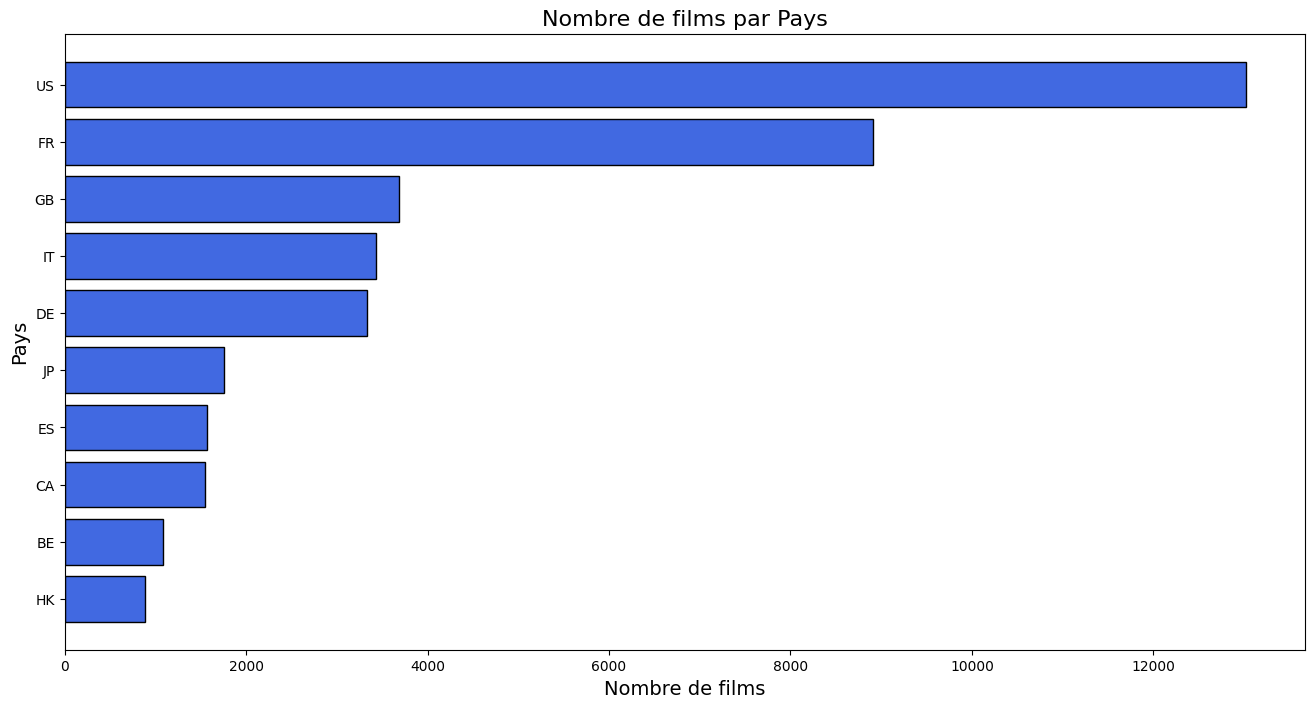

In [10]:
total = df.explode('production_countries')['production_countries'].value_counts()[:10]

plt.figure(figsize=(16, 8))
plt.barh(
    total.index,
    total.values,
    color='royalblue',
    edgecolor='black'
)
plt.title('Nombre de films par Pays', fontsize=16)
plt.xlabel('Nombre de films', fontsize=14)
plt.ylabel('Pays', fontsize=14)
plt.gca().invert_yaxis()
plt.show()

- On cherche si il y a une augmentation ou diminution de la durée des films dans le temps.

In [11]:
boxplotdf = df

boxplotdf["cuts"] = boxplotdf["cuts"].astype(str)
boxplotdf.sort_values("cuts", inplace=True)

fig = px.box(
    data_frame = boxplotdf,
    x = "cuts",
    y = "titre_duree",
    color = "cuts",
    points=False,
)
fig.update_layout(
    title="Durée des Films par Décénnie",
    xaxis_title="Décénnie",
    yaxis_title="Durée des Films",
    showlegend=False
    # legend=dict(
    #     yanchor="top",
    #     y=0.99,
    #     xanchor="left",
    #     x=0.01
    # )
)

fig.show()

- On cherche les 10 films avec le plus de votes sans compter les documentaires, concerts et films d'animations.

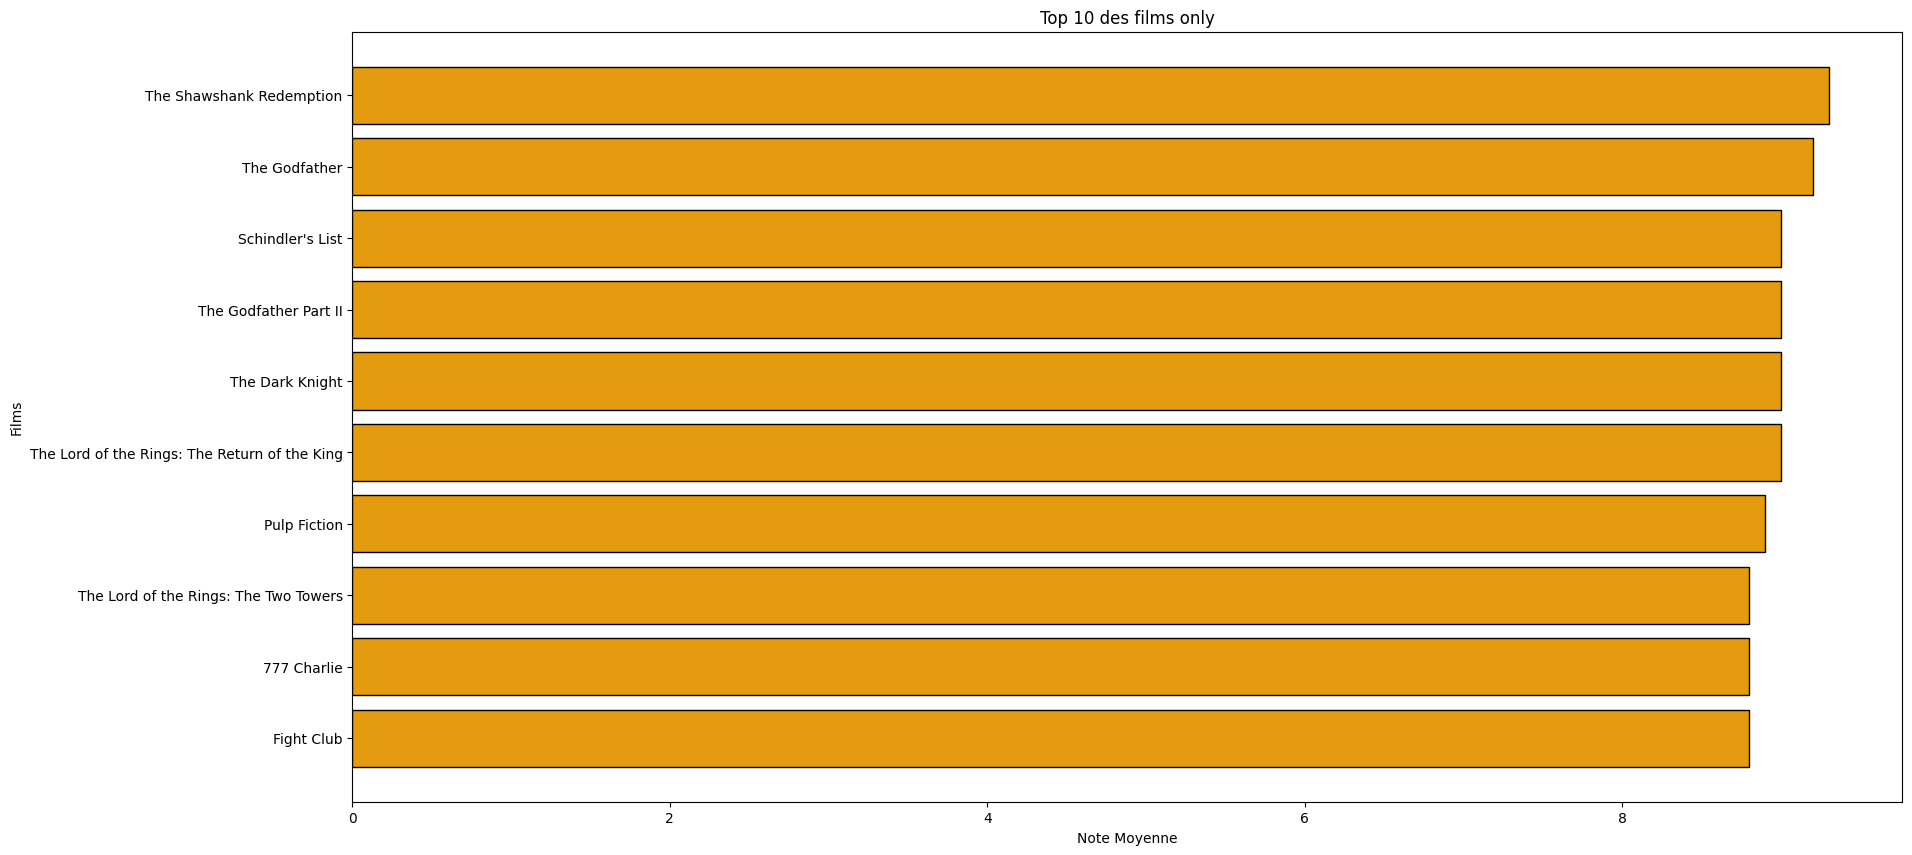

In [12]:
# Je dégage pour les films d'animation les concerts et les docs.
genres_ = ['Animation', 'Music', 'Musical', 'Documentary'] # 'Animation',
df_filtre = df[df['titre_genres'].apply(lambda x: all(g not in x for g in genres_))]
# Je veux uniquement les films ayant eu le plus de vote, je filtre par quantile 0.75 sup only.
df_filtre = df_filtre[df_filtre['rating_votes'] > df_filtre['rating_votes'].quantile(0.75)]

# Groupe les films par la moyenne ratings, ne prend que le top 10
grouped_films = (
    df_filtre.groupby('titre_str')['rating_avg']
    .mean()
    .reset_index()
    .sort_values("rating_avg", ascending=False)
    .head(10)[::-1]
)

plt.figure(figsize=(20, 10))
plt.barh(
    grouped_films['titre_str'],
    grouped_films['rating_avg'],
    color='#e49b0f',
    edgecolor = "black"
)
plt.xlabel('Note Moyenne')
plt.ylabel('Films')
plt.title('Top 10 des films only')
plt.show()


In [13]:
# #  World record of the longest documentary
# # source :https://fr.wikipedia.org/wiki/Ambianc%C3%A9
# longest = actor[actor["titre_duree"] == 43200]
# n = longest[["titre_str", "titre_duree"]].iloc[0]
# heure = n["titre_duree"] // 60
# jours = heure // 24
# print(f"Le film le plus long est {n['titre_str']} d'une durée de {heure} heures soit {jours} jours")
# # All time median for duration
# print(f"All time duration median : {round(actor['titre_duree'].median())} minutes")